In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.plots as plots
import glob
from scipy.stats import binned_statistic, mode

In [8]:
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)

ra = 180
dec = -20.

f2c = {'u': 'purple', 'g': 'blue', 'r': 'green',
        'i': 'cyan', 'z': 'orange', 'y': 'red'}



In [9]:
# OK, let's look at a few internight histograms
db_files = ['baseline_v1.5_10yrs.db',
             'third_obs_pt45v1.5_10yrs.db',
           'third_obs_pt90v1.5_10yrs.db']

Querying database SummaryAllProps with constraint night > 250 and night < 3102 for columns ['fieldDec', 'filter', 'night', 'fiveSigmaDepth', 'observationStartMJD', 'fieldRA']
Found 1685290 visits
Running:  ['baseline_v1_5_10yrs_db_Pass_filter_observationStartMJD_fiveSigmaDepth_night_night_gt_250_and_night_lt_3102_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
baseline_v1.5_10yrs.db [ 27 150  11 165 194 210 196 190 197  74]
baseline_v1.5_10yrs.db, median seaons length (days) 177.5
Querying database SummaryAllProps with constraint night > 250 and night < 3102 for columns ['fieldDec', 'filter', 'night', 'fiveSigmaDepth', 'observationStartMJD', 'fieldRA']
Found 1686752 visits
Running:  ['third_obs_pt45v1_5_10yrs_db_Pass_filter_observationStartMJD_fiveSigmaDepth_night_night_gt_250_and_night_lt_3102_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
third_obs_pt45v1.5_10yrs.db [ 25 186 202 196

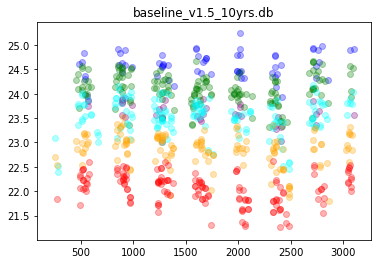

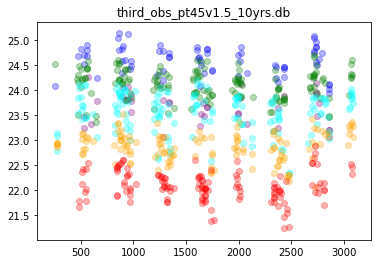

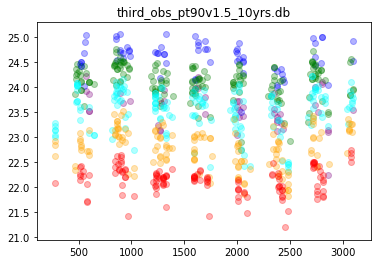

In [10]:
for filename in db_files:

    name = filename.replace('_v1.7_10yrs.db', '').split('/')[-1]

    conn = db.OpsimDatabase(filename)
    bundleList = []
    sql = 'night > 250 and night < %i' %(365*8.5)
    metric = metrics.PassMetric(['filter', 'observationStartMJD', 'fiveSigmaDepth', 'night'])
    slicer = slicers.UserPointsSlicer(ra=ra, dec=dec)
    summaryStats = []
    plotDict = {}
    bundleList.append(metricBundles.MetricBundle(metric,slicer,sql,
                                                 plotDict=plotDict,
                                                 summaryMetrics=summaryStats,
                                                 runName=name))
    bd = metricBundles.makeBundlesDictFromList(bundleList)
    bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
    bg.runAll()
    #bg.plotAll(closefigs=False)

    mv = bundleList[0].metricValues[0]
    
    plt.figure()
    unights = np.unique(mv['night'])
    gaps = np.diff(unights)

    season_breaks = np.where(gaps > 50.)[0]
    night_start=np.array([unights[0]]+unights[season_breaks+1].tolist())
    night_end = np.array(unights[season_breaks].tolist()+[unights[-1]])
    season_lengths = night_end-night_start
    print(name, season_lengths)
    print('%s, median seaons length (days)' % name, np.median(season_lengths))
    
    for filtername in f2c:
        good = np.where(mv['filter'] == filtername)[0]
        plt.scatter(mv['night'][good], mv['fiveSigmaDepth'][good], c=f2c[filtername], alpha=.3)
            
    plt.title(name)
    plt.xlabel('')
    plt.ylabel('')